In [3]:
import pyspark # 
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression as LogisticRegressionPySpark
import pyspark.sql.functions as F 

import os 
import seaborn as sns 
import sklearn # 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import matplotlib # 
import matplotlib.pyplot as plt

os.environ["SPARK_LOCAL_IP"] = '127.0.0.1'
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext._conf.getAll()


[('spark.driver.port', '58347'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.app.id', 'local-1689213863249'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'kubernetes.docker.internal'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell')]

In [4]:
print("pyspark: {}".format(pyspark.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("sklearn: {}".format(sklearn.__version__))



pyspark: 3.0.0
matplotlib: 3.2.1
seaborn: 0.10.1
sklearn: 0.22.1


PySpark: you must define a Spark context and a create a `Spark Session`.

It means that you are creating a point of connection to the `Spark engine`, enabling the engine to run all of the code related to Spark functionality. 


#### Load data set
* PySpark has its own functionality for creating data frames. `No need to use Pandas`

In [6]:
data_path = "D:\per\Codes\cloud_deployment\mlops\data\creditcard.csv\creditcard.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)
labelColumn = "Class"
columns = df.columns
numericCols = columns
numericCols.remove(labelColumn)
print(numericCols)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [7]:
labelColumn

'Class'

In [8]:
df.show(2)

+----+----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+-------------------+------+-----+
|Time|              V1|                 V2|              V3|               V4|                V5|                 V6|                 V7|                V8|                V9|               V10|               V11|               V12|               V13|               V14|              V15|               V16|               V17|               V18|               V19|                V20|               V21|               V22|               V23|       

In [9]:
# convert PySpark data frames into pandas data frames 
df.toPandas().head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


* `PySpark's built-in` functionality to convert the spark data frame into pandas data frame for easier viewing
* If a data frame has a lot of columns it'd be great to convert the `Spark data frame` into `Pandas` for viewing

To train the model, you would need to pass in a vector called `features`

In [10]:
stages = []
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

dfFeatures = df.select(F.col(labelColumn).alias('label'), *numericCols)

* defines the inputs to the assembler so that it knows what columns to transform into the features vector
* also constructing the `VectorAssembler` that will be used later to create a feature vector from the input data. 

In [11]:
dfFeatures

DataFrame[label: int, Time: double, V1: double, V2: double, V3: double, V4: double, V5: double, V6: double, V7: double, V8: double, V9: double, V10: double, V11: double, V12: double, V13: double, V14: double, V15: double, V16: double, V17: double, V18: double, V19: double, V20: double, V21: double, V22: double, V23: double, V24: double, V25: double, V26: double, V27: double, V28: double, Amount: double]

In [15]:
#add cell to the above and create the normal and anomaly data splits 
normal = dfFeatures.filter("Class == 0").sample(withReplacement=False, fraction=0.5, seed=2020)
anomaly = dfFeatures.filter("Class == 1")

normal_train, normal_test = normal.randomSplit([0.8, 0.2], seed=2020)
anomaly_train, anomaly_test = anomaly.randomSplit([0.8, 0.2], seed=2020)

* Normal and anomaly data split similar to scikit-learn's, and split it into training and testing subsets

Now `combine the respective normal & anomaly splits` to form your training and testing sets. 

In [16]:
# No validation set, looking at an 80-20 split btn the training and testing data
# creating the training and testing sets with PySpark's functionality
train = normal_train.union(anomaly_train)
test = normal_test.union(anomaly_test)

Rest of the pipeline with the feature vector

In [17]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(dfFeatures)
train = pipelineModel.transform(train)
test = pipelineModel.transform(test)

selectedCols = ['label', 'features'] + numericCols
train = train.select(selectedCols)
test = test.select(selectedCols)

print("Training Dataset Count: ", train.count())
print("Test Dataset Count: ", test.count())


Training Dataset Count:  113995
Test Dataset Count:  28569


* created a `feature vector` from the data frame using the pipeline. Now, train `logistic regression model` on the feature vector

### Model Training

In [18]:
lr = LogisticRegressionPySpark(featuresCol='features', labelCol='label', maxIter=10)

lrModel = lr.fit(train)

trainingSummary = lrModel.summary
pyspark_auc_score = trainingSummary.areaUnderROC

* Defining the PySpark logistic regression model, training it and finding the AUC Score using the built-in function of the model. 

### Model Evaluation

In [19]:
predictions = lrModel.transform(test)

y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

evaluations = lrModel.evaluate(test)
accuracy = evaluations.accuracy

#display the evaluation metrics
print(f"AUC Score: {roc_auc_score(y_pred, y_true):.3%}")
print(f"PySpark AUC Score: {pyspark_auc_score:.3%}")
print(f"Accuracy Score: {accuracy:.3%}")

AUC Score: 95.169%
PySpark AUC Score: 97.859%
Accuracy Score: 99.902%


* `AUC Score` is calculated using `scikit-learn's` scoring algorithm, while the `PySpark AUC Score metric` comes from the training summary of the `PySpark model`

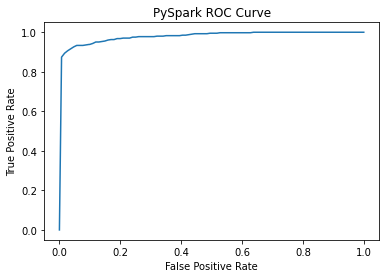

In [20]:
#examine the scores on a graph
pyspark_roc = trainingSummary.roc.toPandas()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PySpark ROC Curve')
plt.plot(pyspark_roc['FPR'], pyspark_roc['TPR'])

> ROC Curve for the *PySpark logistic regression model*
> A perfect ROC Curve would have the *true positive rate* starting at *1.0*, where it continues right to a *false positive rate* value of 1.0. 
* This curve is quite close to that, hence why its area (AUC) is said to be around *0.97997 by PySpark*, keeping in mind a <a>perfect AUC Score</a> is *1.00*

Text(0.5, 15.0, 'predicted')

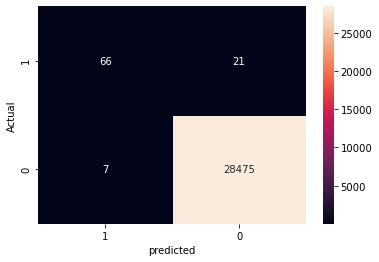

In [21]:
# the confusion matrix to check the model performance
conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('predicted')

* the accuracy of the correctly labeled points for the normal data is very high and is decent for the anomalous data
* anomalies -> the model has a 75.86% accuracy (66/(66+21)) in predicting anomalies
* normal points -> good accuracy of 99.98% (28475/(28475+7))
* haven't tuned the hyperparameter to attain maximum performance. 